In [1]:
# Donne à Colab un accès à un Drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
# Modules nécessaires
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import sys, os
from pathlib import Path
import glob
import itertools

from sklearn.model_selection import train_test_split

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, TerminateOnNaN, EarlyStopping

from keras.models import load_model
from sklearn.metrics import classification_report, confusion_matrix

In [3]:
tf.test.gpu_device_name()

'/device:GPU:0'

In [ ]:
## Copie locale des fichiers (tous dans le même dossier, changer le chemin d'accès)
!cp -r "/content/drive/MyDrive/Leukopy/Data_PBC/Data_PBC.zip" .
!unzip Data_PBC.zip

## Copie locale des fichiers (sous-répertoires training et testing => c'était utilisé avec flow_from_directory)
#!cp -r "/content/drive/MyDrive/Leukopy/Data/Data.zip" .
#!unzip Data.zip

In [5]:
## Toutes les données dans un seul et même dossier :
liste = glob.glob('./Data_PBC/*/*.jpg')
liste = list(map(lambda x : [x, x.split('/')[2]], liste))

df = pd.DataFrame(liste, columns = ['img_path', 'label'])
df, df_test = train_test_split(df, test_size = 0.2)
df_train, df_valid = train_test_split(df, test_size = 0.12)

In [6]:
df_train["label"].value_counts(normalize = True)

EO     0.186123
PLT    0.137342
BNE    0.097309
SNE    0.096804
ERB    0.092094
MO     0.084104
BA     0.073339
LY     0.071320
MY     0.067283
MMY    0.058705
PMY    0.035576
Name: label, dtype: float64

In [ ]:
## Données pré-séparées dans deux dossiers, training et testing :
# Chemin d'accès aux images
#liste_train = glob.glob('./Data/training/*/*.jpg')
#liste_test = glob.glob('./Data/testing/*/*.jpg')

# Extrait le label de chaque image
#liste_train = list(map(lambda x : [x, x.split('/')[3]], liste_train))
#liste_test = list(map(lambda x : [x, x.split('/')[3]], liste_test))

# DataFrames
#df_train = pd.DataFrame(liste_train, columns = ['img_path', 'label'])
#df_test = pd.DataFrame(liste_test, columns = ['img_path', 'label'])

# Jeu de validation
#df_train, df_valid = train_test_split(df_train, test_size = 0.12)

In [10]:
# Preprocessing
batch_size = 32
img_height  = 256
img_width = 256

# Augmentation seulement sur le jeu d'entraînement. On normalise toutes les images.
train_generator = ImageDataGenerator(rotation_range = 90,
                                     horizontal_flip = True, 
                                     vertical_flip = True, 
                                     rescale = 1./255)
valid_generator = ImageDataGenerator(rescale = 1./255)
test_generator = ImageDataGenerator(rescale = 1./255)

# Batchs, redimensionnement, chargement des images
training_set = train_generator.flow_from_dataframe(df_train, 
                                                   directory = None, # utilise x_col
                                                   x_col = 'img_path', 
                                                   y_col = 'label',
                                                   target_size = (img_height, img_width), 
                                                   color_mode = 'rgb',
                                                   classes = None,   # utilise y_col
                                                   class_mode = 'categorical', 
                                                   batch_size = batch_size, 
                                                   shuffle = True)

validation_set = valid_generator.flow_from_dataframe(df_valid, 
                                                     directory = None, # utilise x_col
                                                     x_col = 'img_path', 
                                                     y_col = 'label',
                                                     target_size = (img_height, img_width), 
                                                     color_mode = 'rgb',
                                                     classes = None,   # utilise y_col
                                                     class_mode = 'categorical', 
                                                     batch_size = batch_size, 
                                                     shuffle = True)

testing_set = test_generator.flow_from_dataframe(df_test, 
                                                 directory = None, # utilise x_col
                                                 x_col = 'img_path', 
                                                 y_col = 'label',
                                                 target_size = (img_height, img_width),
                                                 color_mode = 'rgb',
                                                 classes = None,   # utilise y_col
                                                 class_mode = 'categorical', 
                                                 batch_size = batch_size, 
                                                 shuffle = False)


Found 11890 validated image filenames belonging to 11 classes.
Found 1622 validated image filenames belonging to 11 classes.
Found 3379 validated image filenames belonging to 11 classes.


In [11]:
# Correspondance indices/labels (ordre alphanumérique):
print('Train :', training_set.class_indices)
print('Valid :', validation_set.class_indices)
print('Test  :', testing_set.class_indices)

label_map = training_set.class_indices

Train : {'BA': 0, 'BNE': 1, 'EO': 2, 'ERB': 3, 'LY': 4, 'MMY': 5, 'MO': 6, 'MY': 7, 'PLT': 8, 'PMY': 9, 'SNE': 10}
Valid : {'BA': 0, 'BNE': 1, 'EO': 2, 'ERB': 3, 'LY': 4, 'MMY': 5, 'MO': 6, 'MY': 7, 'PLT': 8, 'PMY': 9, 'SNE': 10}
Test  : {'BA': 0, 'BNE': 1, 'EO': 2, 'ERB': 3, 'LY': 4, 'MMY': 5, 'MO': 6, 'MY': 7, 'PLT': 8, 'PMY': 9, 'SNE': 10}


In [12]:
# Modèle LeNet

model = Sequential(
    [layers.Conv2D(filters = 30,            # Change 32
                   kernel_size = (5,5),
                   activation = 'relu',
                   padding = 'valid', 
                   input_shape = (img_height, img_width, 3)),
     layers.MaxPooling2D(pool_size = (2,2)),
     layers.Conv2D(filters = 16,            # Change 32
                   kernel_size = (3,3),     # Change (5,5)
                   activation = 'relu',
                   padding = 'valid'),
     layers.MaxPooling2D(pool_size = (2,2)),
     layers.Dropout(rate = 0.2),
     layers.Flatten(),
     layers.Dense(units = 128, activation = 'relu'),
#     layers.Dense(units = 8, activation  = 'softmax'), 
     layers.Dense(units = 11, activation  = 'softmax')
     ])

model.compile(optimizer = 'adam',
              loss = "categorical_crossentropy",
              metrics = ["accuracy"])

In [13]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 252, 252, 30)      2280      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 126, 126, 30)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 124, 124, 16)      4336      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 62, 62, 16)        0         
_________________________________________________________________
dropout (Dropout)            (None, 62, 62, 16)        0         
_________________________________________________________________
flatten (Flatten)            (None, 61504)             0         
_________________________________________________________________
dense (Dense)                (None, 128)               7

In [14]:
# Callbacks :
TON = TerminateOnNaN()

save_model = ModelCheckpoint(filepath = '/content/drive/MyDrive/Leukopy/LeNetModel/model_trainingsave', 
                             monitor = 'val_loss', 
                             save_best_only = True,
                             save_weights_only = False,
                             save_freq = 'epoch')

control_lr = ReduceLROnPlateau(monitor = 'val_loss',
                               factor = 0.1, 
                               patience = 3, 
                               verbose = 1, 
                               mode = 'min')

early_stopping = EarlyStopping(monitor = "val_loss", 
                               patience = 6, 
                               mode = 'min',
                               restore_best_weights = True)

In [15]:
# Entraînement :

history = model.fit(training_set, epochs = 22, validation_data = validation_set, 
                    callbacks = [TON, save_model, control_lr, early_stopping])

Epoch 1/22
372/372 [==============================] - 195s 440ms/step - loss: 1.5938 - accuracy: 0.4712 - val_loss: 1.0370 - val_accuracy: 0.6375
INFO:tensorflow:Assets written to: /content/drive/MyDrive/Leukopy/LeNetModel/model_trainingsave/assets
Epoch 2/22
372/372 [==============================] - 163s 439ms/step - loss: 0.9207 - accuracy: 0.6714 - val_loss: 0.7755 - val_accuracy: 0.7263
INFO:tensorflow:Assets written to: /content/drive/MyDrive/Leukopy/LeNetModel/model_trainingsave/assets
Epoch 3/22
372/372 [==============================] - 163s 438ms/step - loss: 0.7498 - accuracy: 0.7194 - val_loss: 0.6765 - val_accuracy: 0.7435
INFO:tensorflow:Assets written to: /content/drive/MyDrive/Leukopy/LeNetModel/model_trainingsave/assets
Epoch 4/22
372/372 [==============================] - 162s 437ms/step - loss: 0.6341 - accuracy: 0.7577 - val_loss: 0.6970 - val_accuracy: 0.7374
Epoch 5/22
372/372 [==============================] - 162s 435ms/step - loss: 0.5716 - accuracy: 0.7762 - v

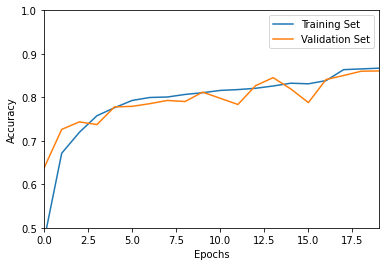

In [16]:
# Courbe d'entraînement (point de comparaison à 11 classes):

training_accuracy = history.history['accuracy']
validation_accuracy = history.history['val_accuracy']

plt.figure()
plt.plot(np.arange(22), training_accuracy, label = 'Training Set')
plt.plot(np.arange(22), validation_accuracy, label = 'Validation Set')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.xlim([0,19])
plt.ylim([0.5,1])
plt.legend()
plt.show()

In [ ]:
# Évaluation de l'accuracy sur le jeu de test (point de comparaison à 8 classes):
model.evaluate(testing_set)

107/107 [==============================] - 10s 92ms/step - loss: 0.1519 - accuracy: 0.9511


[0.15192344784736633, 0.951083779335022]

In [17]:
# Évaluation de l'accuracy sur le jeu de test (point de comparaison à 11 classes):
model.evaluate(testing_set)

106/106 [==============================] - 10s 96ms/step - loss: 0.3611 - accuracy: 0.8574


[0.3611157536506653, 0.8573542237281799]

In [ ]:
# Test avec 32 filtres dans les couches de convolution, et kernel_size = (5,5) pour les 2 couches
model.evaluate(testing_set)

In [18]:
# Sauvegarde le modèle ainsi que l'état de l'optimizer : permet de récupérer la totalité du modèle et de poursuivre l'entraînement si besoin

model.save("/content/drive/MyDrive/Leukopy/LeNetModel/model_fullsave")

INFO:tensorflow:Assets written to: /content/drive/MyDrive/Leukopy/LeNetModel/model_fullsave/assets


In [50]:
# Sauvegarde des poids du modèle

model.save_weights("/content/drive/MyDrive/Leukopy/LeNetModel/weights/model_weightssave", save_format = "tf")

In [16]:
## Copie locale des fichiers
#!cp -r "/content/drive/MyDrive/Leukopy/LeNetModel/model_fullsave" .

In [17]:
# Charge le modèle entraîné complet
#model = load_model("/content/model_fullsave")

In [19]:
# Évaluation de l'accuracy sur le jeu de test (point de comparaison à 11 classes):
#model.evaluate(testing_set)

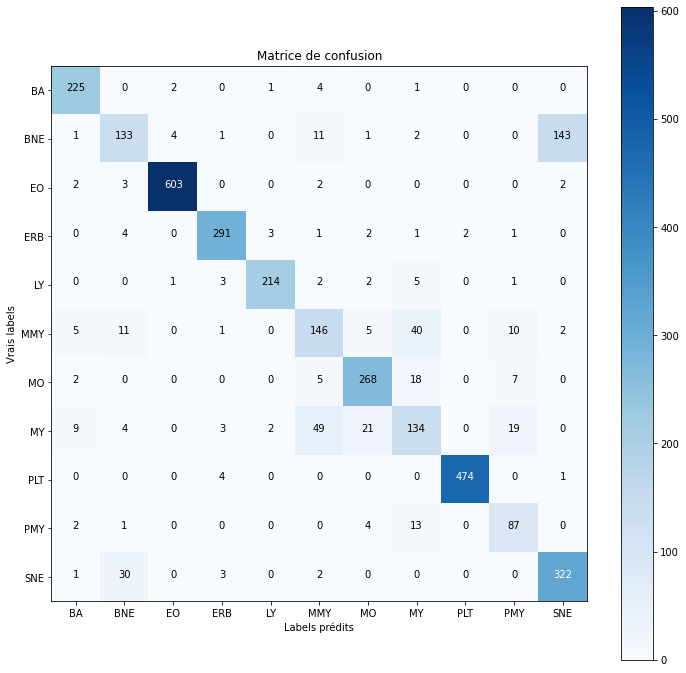

Classification Report : 


precision    recall  f1-score support
BA   0.910931  0.965665    0.9375     233
BNE  0.715054  0.449324  0.551867     296
EO   0.988525  0.985294  0.986907     612
ERB   0.95098  0.954098  0.952537     305
LY   0.972727  0.938596  0.955357     228
MMY  0.657658  0.663636  0.660633     220
MO   0.884488  0.893333  0.888889     300
MY   0.626168  0.556017  0.589011     241
PLT  0.995798  0.989562   0.99267     479
PMY     0.696  0.813084      0.75     107
SNE  0.685106  0.899441  0.777778     358

In [20]:
# Matrice de confusion + rapport de classification ("présentable")

def print_classification_report(testing_set, labels):

  # Prédiction : utilise le jeu de test (testing_set)
  predictions = model.predict(testing_set)
  y_pred = tf.argmax(predictions, axis = 1)

  # Calcul et affichage de la matrice de confusion
  cnf_matrix = confusion_matrix(testing_set.classes, y_pred)
  classes = range(len(labels))
  
  plt.figure(figsize = (12,12))
  plt.imshow(cnf_matrix, interpolation = 'nearest', cmap = 'Blues')
  plt.title("Matrice de confusion")
  plt.colorbar()

  tick_marks = np.arange(len(labels))
  plt.xticks(tick_marks, labels)
  plt.yticks(tick_marks, labels)

  for i, j in itertools.product(range(cnf_matrix.shape[0]), 
                                range(cnf_matrix.shape[1])):
    plt.text(j, i, cnf_matrix[i, j],
             horizontalalignment = "center",
             color = "white" if cnf_matrix[i, j] > ( cnf_matrix.max() / 2) else "black")

  plt.ylabel('Vrais labels')
  plt.xlabel('Labels prédits')
  plt.show()

  # Rapport de classification 
  report = classification_report(testing_set.classes, y_pred, target_names = labels, output_dict = True)

  df_report = pd.DataFrame(index = list(report.keys())[:-3], columns = list(report["BA"].keys()))
  for key in list(report.keys())[:-3]:
    for column in list(report["BA"].keys()):
      df_report.loc[key, column] = report[key][column]
  
  print("Classification Report : ")
  return display(df_report)

label_map = training_set.class_indices
print_classification_report(testing_set, label_map)

In [21]:
# Matrice de confusion et rapport de classification ("version light"):

from sklearn.metrics import classification_report, confusion_matrix

predictions = model.predict(testing_set)
y_pred = tf.argmax(predictions, axis = 1)

print("Confusion Matrix")
print(confusion_matrix(testing_set.classes, y_pred))

print("Classification Report")
print(classification_report(testing_set.classes, y_pred, target_names = label_map))


Confusion Matrix
[[225   0   2   0   1   4   0   1   0   0   0]
 [  1 133   4   1   0  11   1   2   0   0 143]
 [  2   3 603   0   0   2   0   0   0   0   2]
 [  0   4   0 291   3   1   2   1   2   1   0]
 [  0   0   1   3 214   2   2   5   0   1   0]
 [  5  11   0   1   0 146   5  40   0  10   2]
 [  2   0   0   0   0   5 268  18   0   7   0]
 [  9   4   0   3   2  49  21 134   0  19   0]
 [  0   0   0   4   0   0   0   0 474   0   1]
 [  2   1   0   0   0   0   4  13   0  87   0]
 [  1  30   0   3   0   2   0   0   0   0 322]]
Classification Report
              precision    recall  f1-score   support

          BA       0.91      0.97      0.94       233
         BNE       0.72      0.45      0.55       296
          EO       0.99      0.99      0.99       612
         ERB       0.95      0.95      0.95       305
          LY       0.97      0.94      0.96       228
         MMY       0.66      0.66      0.66       220
          MO       0.88      0.89      0.89       300
          

In [ ]:
############################################### ANALYSE DES RÉSULTATS ########################################################

In [22]:
# DF avec le résultat et le label de toutes les images du test :
df_results = pd.DataFrame(data = {"real":testing_set.classes,
                                  "pred":y_pred, 
                                  "img_path":df_test["img_path"]})

# Tri des images : mal classé (df_false), bien classé (df_true):
df_false = df_results[df_results["real"] != df_results["pred"]].reset_index(drop = True)
df_true = df_results[df_results["real"] == df_results["pred"]].reset_index(drop = True)

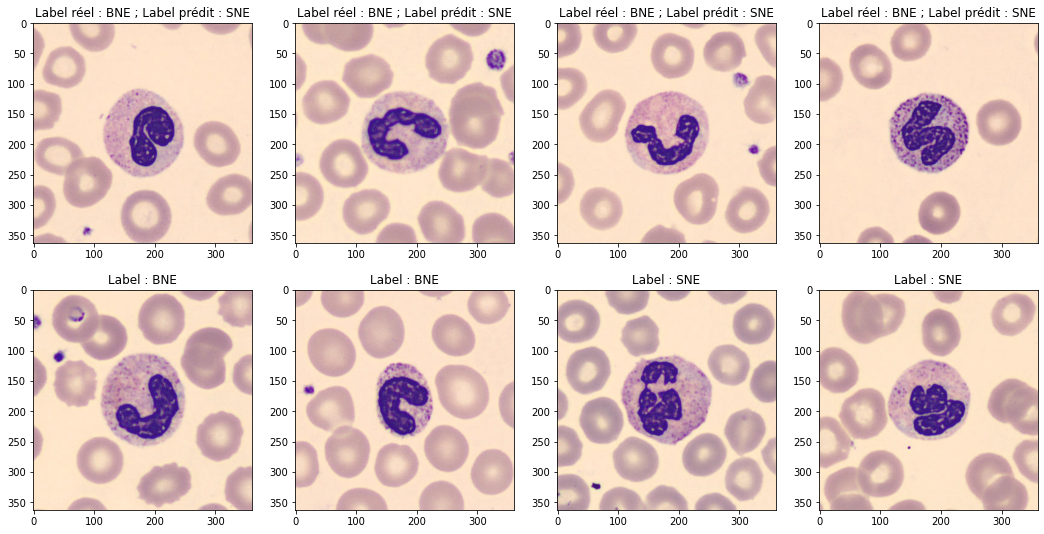

In [25]:
# Confusion BNE/SNE : labels 1 et 10

conf = df_false[((df_false["real"] == 1) & (df_false["pred"] == 10)) | ((df_false["real"] == 10) & (df_false["pred"] == 1))]
BNE = df_true[((df_true["real"] == 1) & (df_true["pred"] == 1))]
SNE = df_true[((df_true["real"] == 10) & (df_true["pred"] == 10))]

plt.figure(figsize = (18,9))
i = 1
for id in np.random.choice(conf.index, size = 4, replace = False):
  plt.subplot(2,4,i)
  plt.imshow(plt.imread(conf.loc[id,"img_path"]))
  plt.title("Label réel : %s ; Label prédit : %s"%(list(label_map.keys())[conf.loc[id,"real"]],
                                                   list(label_map.keys())[conf.loc[id,"pred"]]))
  i += 1

for id in np.random.choice(BNE.index, size = 2, replace = False):
  plt.subplot(2,4,i)
  plt.imshow(plt.imread(BNE.loc[id,"img_path"]))
  plt.title("Label : %s"%(list(label_map.keys())[BNE.loc[id,"real"]]))
  i += 1

for id in np.random.choice(SNE.index, size = 2, replace = False):
  plt.subplot(2,4,i)
  plt.imshow(plt.imread(SNE.loc[id,"img_path"]))
  plt.title("Label : %s"%(list(label_map.keys())[SNE.loc[id,"real"]]))
  i += 1

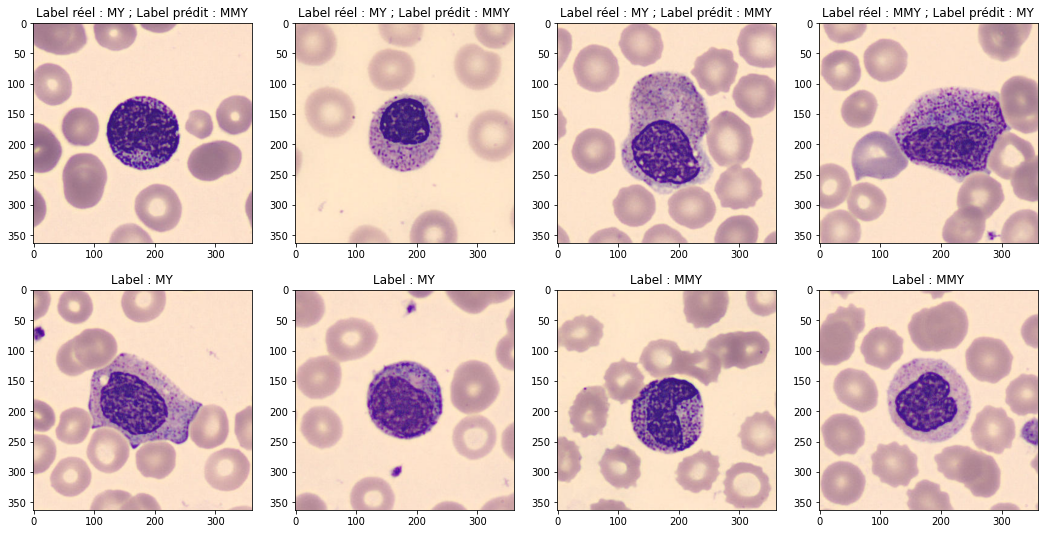

In [26]:
# Confusion MY/MMY : labels 5 et 7
conf2 = df_false[((df_false["real"] == 5) & (df_false["pred"] == 7)) | ((df_false["real"] == 7) & (df_false["pred"] == 5))]
MY = df_true[((df_true["real"] == 7) & (df_true["pred"] == 7))]
MMY = df_true[((df_true["real"] == 5) & (df_true["pred"] == 5))]

plt.figure(figsize = (18,9))
i = 1
for id in np.random.choice(conf2.index, size = 4, replace = False):
  plt.subplot(2,4,i)
  plt.imshow(plt.imread(conf2.loc[id,"img_path"]))
  plt.title("Label réel : %s ; Label prédit : %s"%(list(label_map.keys())[conf2.loc[id,"real"]],
                                                   list(label_map.keys())[conf2.loc[id,"pred"]]))
  i += 1

for id in np.random.choice(MY.index, size = 2, replace = False):
  plt.subplot(2,4,i)
  plt.imshow(plt.imread(MY.loc[id,"img_path"]))
  plt.title("Label : %s"%(list(label_map.keys())[MY.loc[id,"real"]]))
  i += 1

for id in np.random.choice(MMY.index, size = 2, replace = False):
  plt.subplot(2,4,i)
  plt.imshow(plt.imread(MMY.loc[id,"img_path"]))
  plt.title("Label : %s"%(list(label_map.keys())[MMY.loc[id,"real"]]))
  i += 1

In [ ]:
##################################################### Grad-CAM ##############################################################

In [27]:
df_results.head(5)

real  pred                            img_path
9954      8     8  ./Data_PBC/PLT/PLATELET_311500.jpg
5415     10    10       ./Data_PBC/SNE/SNE_970608.jpg
15078     7     6         ./Data_PBC/MY/MY_862763.jpg
1877      2     2         ./Data_PBC/EO/EO_402029.jpg
884       1    10        ./Data_PBC/BNE/BNE_67367.jpg

In [28]:
df_test.head(30)

img_path label
9954   ./Data_PBC/PLT/PLATELET_311500.jpg   PLT
5415        ./Data_PBC/SNE/SNE_970608.jpg   SNE
15078         ./Data_PBC/MY/MY_862763.jpg    MY
1877          ./Data_PBC/EO/EO_402029.jpg    EO
884          ./Data_PBC/BNE/BNE_67367.jpg   BNE
8210         ./Data_PBC/ERB/ERB_94990.jpg   ERB
15822         ./Data_PBC/MO/MO_536614.jpg    MO
6211        ./Data_PBC/SNE/SNE_603329.jpg   SNE
5015        ./Data_PBC/PMY/PMY_298535.jpg   PMY
781          ./Data_PBC/BNE/BNE_41833.jpg   BNE
7059        ./Data_PBC/MMY/MMY_259996.jpg   MMY
2942          ./Data_PBC/EO/EO_825733.jpg    EO
3733          ./Data_PBC/EO/EO_105120.jpg    EO
13069         ./Data_PBC/BA/BA_557453.jpg    BA
7233        ./Data_PBC/MMY/MMY_290219.jpg   MMY
17           ./Data_PBC/BNE/BNE_58419.jpg   BNE
5220        ./Data_PBC/PMY/PMY_958409.jpg   PMY
12277         ./Data_PBC/BA/BA_347386.jpg    BA
6862        ./Data_PBC/SNE/SNE_569771.jpg   SNE
1788          ./Data_PBC/EO/EO_240232.jpg    EO
322         ./Data_PBC/BNE/BNE_863051.jpg   BNE
4131          ./Data_PBC/EO/EO_645275.jpg    EO
14226         ./Data_PBC/LY/LY_530877.jpg    LY
10308   ./Data_PBC/PLT/PLATELET_45774.jpg   PLT
5116        ./Data_PBC/PMY/PMY_988901.jpg   PMY
2237          ./Data_PBC/EO/EO_213515.jpg    EO
10602  ./Data_PBC/PLT/PLATELET_590291.jpg   PLT
4558           ./Data_PBC/EO/EO_78307.jpg    EO
14299         ./Data_PBC/LY/LY_668316.jpg    LY
8857        ./Data_PBC/ERB/ERB_132298.jpg   ERB

In [39]:
def get_img_array(img_path, size = (img_height, img_width)):
  img = keras.preprocessing.image.load_img(img_path, target_size = size)
  # 'array' : shape (img_height, img_width, 3)
  array = keras.preprocessing.image.img_to_array(img)
  # Ajout d'une dimension pour transformer l'array en batch (1, height, width, 3)
  array = np.expand_dims(array, axis=0)
  return array

def make_gradcam_heatmap(img_array, model, last_conv_layer_name, pred_index=None):
  # First, we create a model that maps the input image to the activations
  # of the last conv layer as well as the output predictions
  grad_model = tf.keras.models.Model(
      [model.inputs], [model.get_layer(last_conv_layer_name).output, model.output])

  # Then, we compute the gradient of the top predicted class for our input image
  # with respect to the activations of the last conv layer
  with tf.GradientTape() as tape:
      last_conv_layer_output, preds = grad_model(img_array)
      if pred_index is None:
        pred_index = tf.argmax(preds[0])
      class_channel = preds[:, pred_index]

  # This is the gradient of the output neuron (top predicted or chosen)
  # with regard to the output feature map of the last conv layer
  grads = tape.gradient(class_channel, last_conv_layer_output)

  # This is a vector where each entry is the mean intensity of the gradient
  # over a specific feature map channel
  pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

  # We multiply each channel in the feature map array
  # by "how important this channel is" with regard to the top predicted class
  # then sum all the channels to obtain the heatmap class activation
  last_conv_layer_output = last_conv_layer_output[0]
  heatmap = last_conv_layer_output @ pooled_grads[..., tf.newaxis]
  heatmap = tf.squeeze(heatmap)

  # For visualization purpose, we will also normalize the heatmap between 0 & 1
  heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
  return heatmap.numpy()

def save_and_display_gradcam(img_path, heatmap, cam_path = "cam.jpg", alpha = 0.5):
  # Load the original image
  img = keras.preprocessing.image.load_img(img_path)
  img = keras.preprocessing.image.img_to_array(img)

  # Rescale heatmap to a range 0-255
  heatmap = np.uint8(255*heatmap)

  # Use jet colormap to colorize heatmap
  jet = cm.get_cmap("jet")

  # Use RGB values of the colormap
  jet_colors = jet(np.arange(256))[:, :3]
  jet_heatmap = jet_colors[heatmap]

  # Create an image with RGB colorized heatmap
  jet_heatmap = keras.preprocessing.image.array_to_img(jet_heatmap)
  jet_heatmap = jet_heatmap.resize((img.shape[1], img.shape[0]))
  jet_heatmap = keras.preprocessing.image.img_to_array(jet_heatmap)

  # Superimpose the heatmap on original image
  superimposed_img = jet_heatmap*alpha + img
  superimposed_img = keras.preprocessing.image.array_to_img(superimposed_img)

  # Save the superimposed image
  superimposed_img.save(cam_path)

  # Display Grad CAM
  #display(Image(cam_path))
  #plt.imshow(plt.imread(cam_path))
  #plt.show()
  
  return cam_path


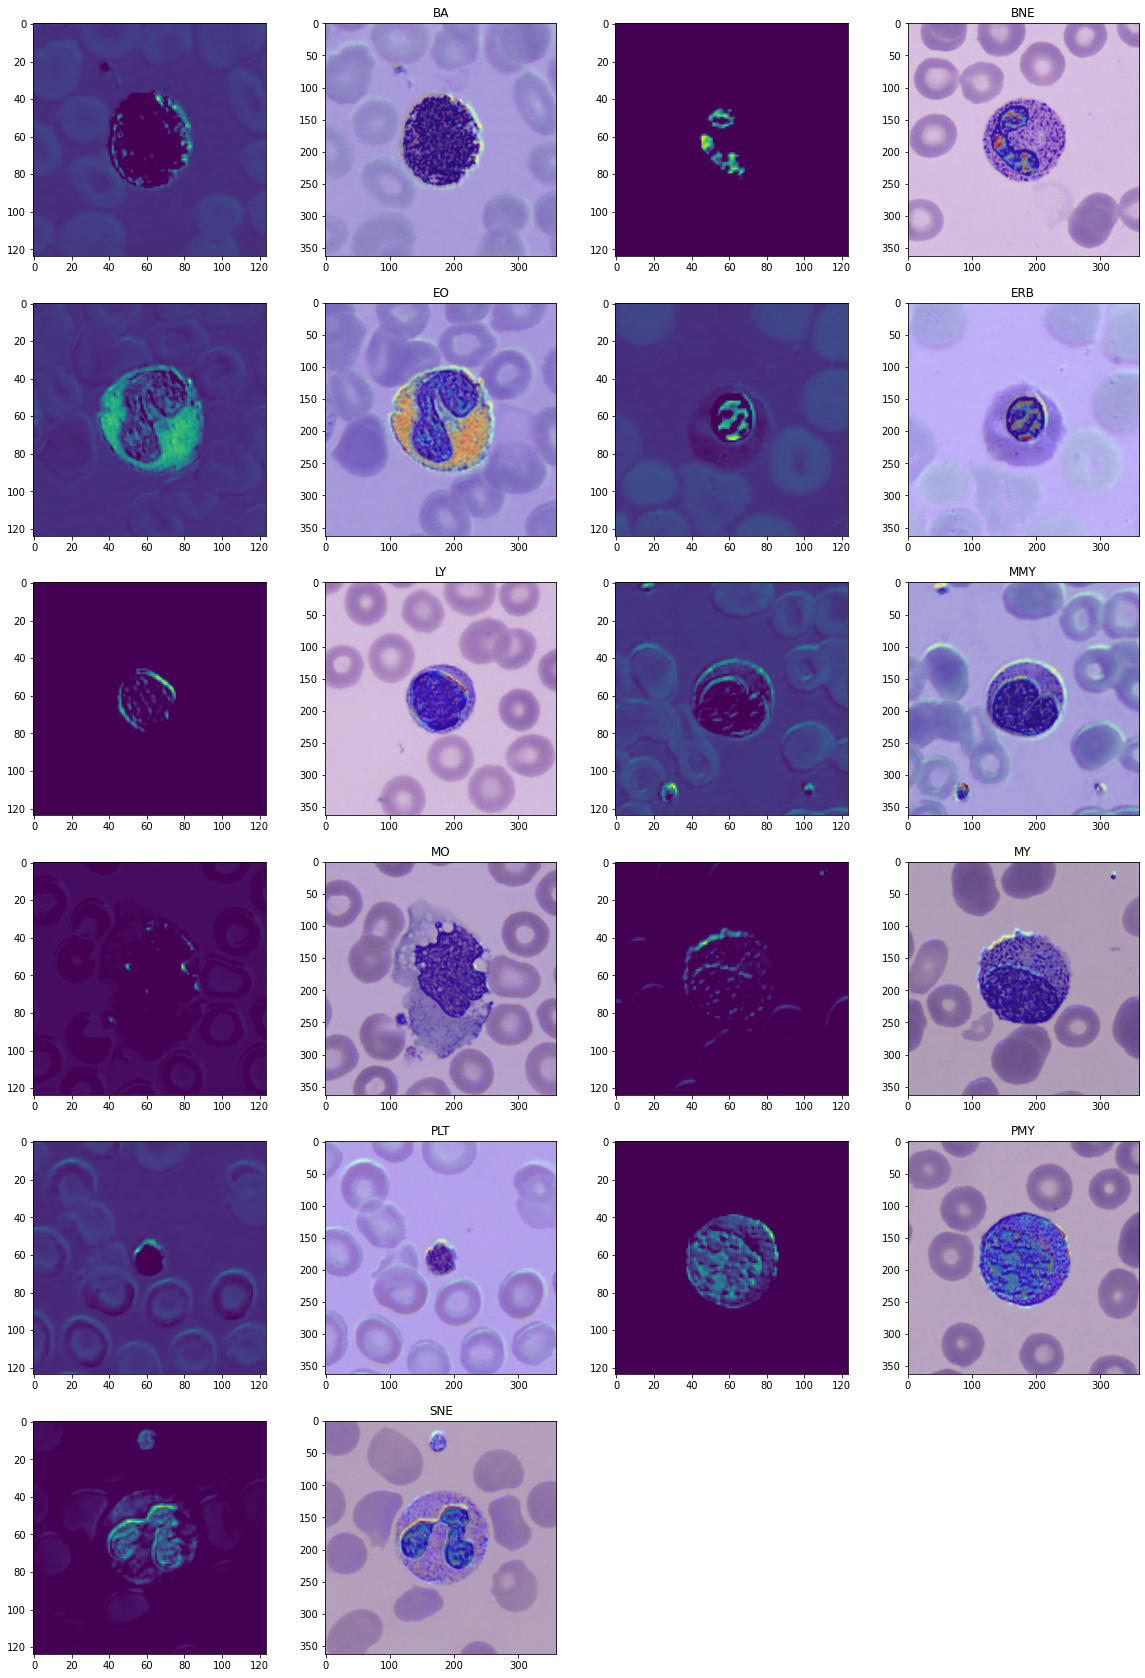

In [48]:
###################################### Grad-CAM - bien classées ##############################################################
from IPython.display import Image, display
import matplotlib.cm as cm

# On récupère le nom de la dernière couche de convolution du modèle (grâce à model.summary):
last_conv_layer_name = "conv2d_1"

plt.figure(figsize = (20,30))

i = 1
for label in np.arange(0,11):

  # Tire un index au hasard parmi les index d'une même classe de cellules
  df_temp = df_true[df_true["real"] == label]
  idx = np.random.choice(a = df_temp.index)

  # Récupère le chemin d'accès de l'image dont on vient de tirer l'index          
  img_path = df_temp.loc[idx,"img_path"]

  # Resize + Rescale + Batch
  img_array = get_img_array(img_path)/255

  # Grad-CAM Heatmap + superposition
  heatmap = make_gradcam_heatmap(img_array, model, last_conv_layer_name)
  cam_path = save_and_display_gradcam(img_path, heatmap)

  plt.subplot(6,4,i)
  #plt.matshow(heatmap)
  plt.imshow(heatmap)

  plt.subplot(6,4,i+1)
  plt.imshow(plt.imread(cam_path))
  plt.title(list(label_map.keys())[label])

  i+=2



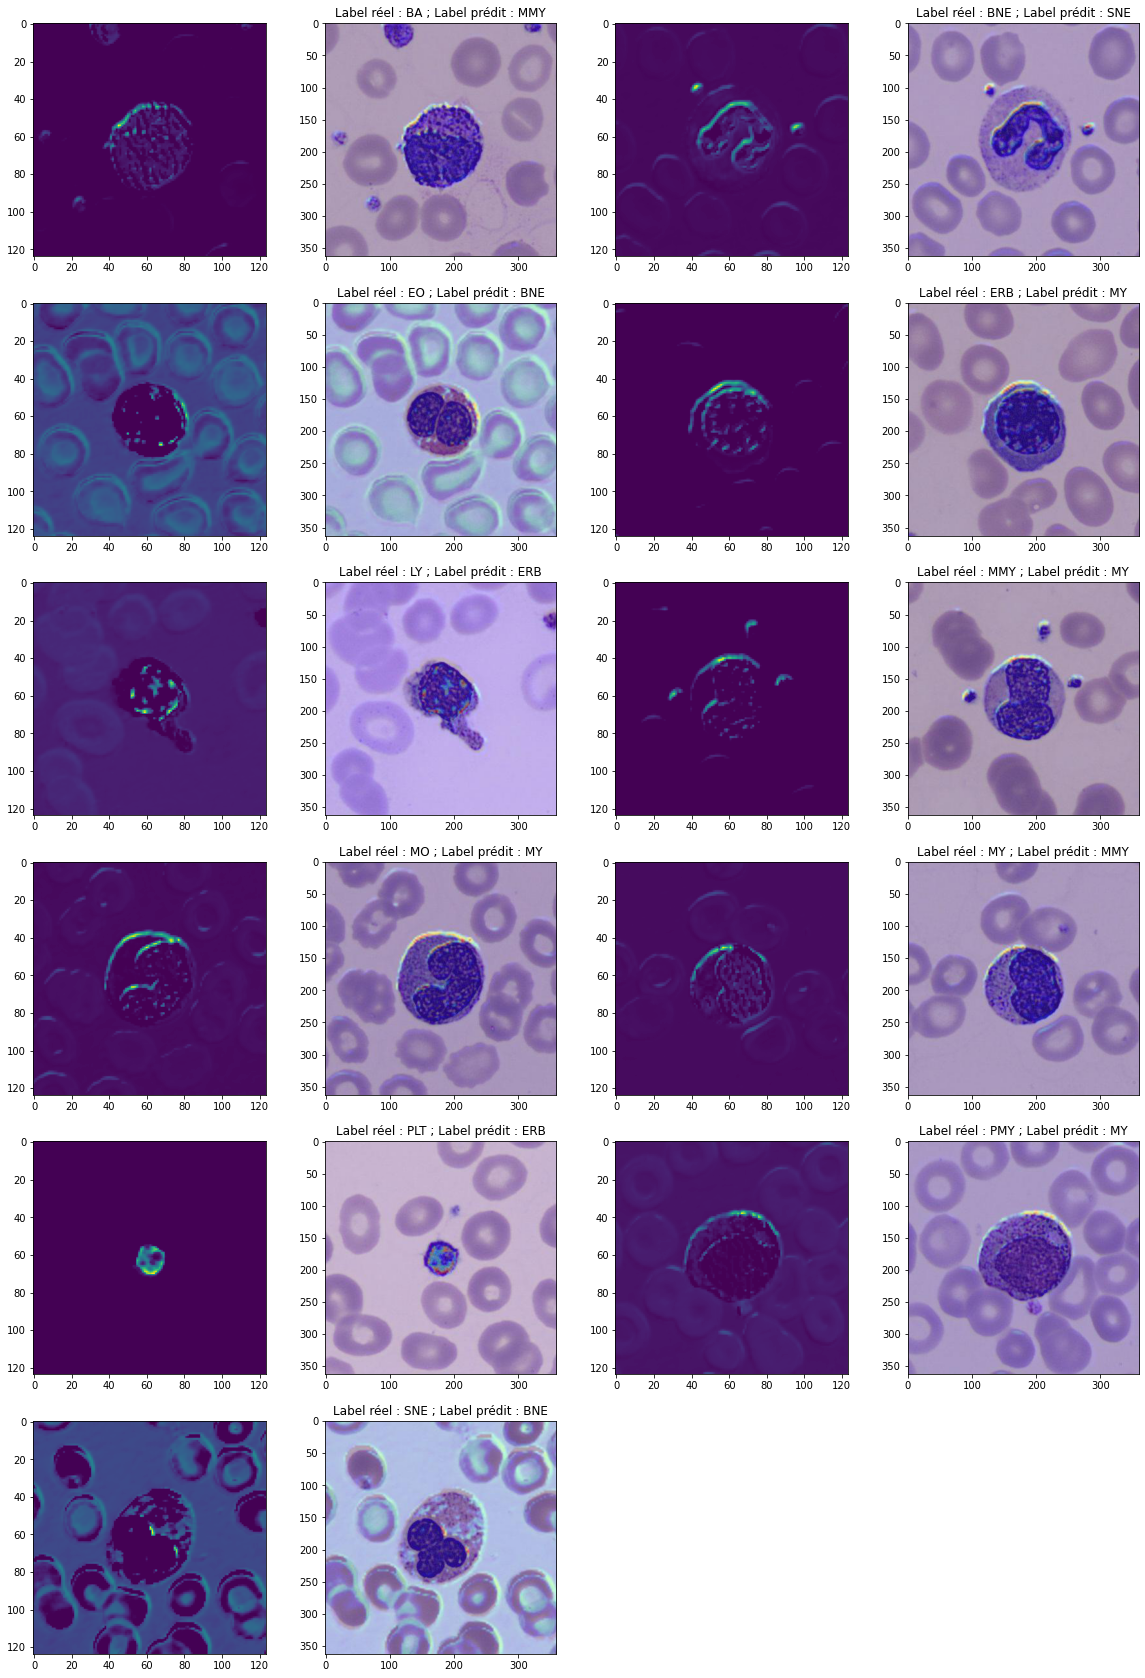

In [47]:
###################################### Grad-CAM - mal classées ###############################################################

plt.figure(figsize = (20,30))

i = 1
for label in np.arange(0,11):
  
  # Tire un index au hasard parmi les index d'une même classe de cellules
  df_temp = df_false[df_false["real"] == label]
  idx = np.random.choice(a = df_temp.index)

  # Récupère le chemin d'accès de l'image dont on vient de tirer l'index          
  img_path = df_temp.loc[idx,"img_path"]

  # Resize + Rescale + Batch
  img_array = get_img_array(img_path)/255

  # Grad-CAM Heatmap + superposition
  heatmap = make_gradcam_heatmap(img_array, model, last_conv_layer_name)
  cam_path = save_and_display_gradcam(img_path, heatmap)

  plt.subplot(6,4,i)
  #plt.matshow(heatmap)
  plt.imshow(heatmap)

  plt.subplot(6,4,i+1)
  plt.imshow(plt.imread(cam_path))
  plt.title("Label réel : %s ; Label prédit : %s"%(list(label_map.keys())[df_temp.loc[idx,"real"]],
                                                   list(label_map.keys())[df_temp.loc[idx,"pred"]]))
  
  i+=2

In [52]:
# Charge le modèle entraîné complet
new_model = load_model("/content/drive/MyDrive/Leukopy/LeNetModel/model_fullsave")

In [53]:
# Évaluation de l'accuracy sur le jeu de test (point de comparaison à 11 classes): 
# => c'est beaucoup trop long, il y a quelque chose que je ne comprends pas...
new_model.evaluate(testing_set)

  25777/Unknown - 2349s 91ms/step - loss: 0.3611 - accuracy: 0.8574

KeyboardInterrupt: ignored